Домашнее задание:
Используя файл Web5.ipynb (он в полезных ссылках):
Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).
Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.layers import SimpleRNN, LSTM, SimpleRNNCell, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D

import tensorflow as tf

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2022-02-25 19:47:38--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 173.194.216.101, 173.194.216.113, 173.194.216.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5noq9008uqerg9ghoalv4v6cscjskjj7/1645818450000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download [following]
--2022-02-25 19:47:38--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5noq9008uqerg9ghoalv4v6cscjskjj7/1645818450000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-08-c0-docs.googleusercontent.com (doc-08-c0

In [3]:
data = pd.read_csv('/content/airline-passengers.csv')
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
data.Month.unique()

array(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10', '1949-11', '1949-12',
       '1950-01', '1950-02', '1950-03', '1950-04', '1950-05', '1950-06',
       '1950-07', '1950-08', '1950-09', '1950-10', '1950-11', '1950-12',
       '1951-01', '1951-02', '1951-03', '1951-04', '1951-05', '1951-06',
       '1951-07', '1951-08', '1951-09', '1951-10', '1951-11', '1951-12',
       '1952-01', '1952-02', '1952-03', '1952-04', '1952-05', '1952-06',
       '1952-07', '1952-08', '1952-09', '1952-10', '1952-11', '1952-12',
       '1953-01', '1953-02', '1953-03', '1953-04', '1953-05', '1953-06',
       '1953-07', '1953-08', '1953-09', '1953-10', '1953-11', '1953-12',
       '1954-01', '1954-02', '1954-03', '1954-04', '1954-05', '1954-06',
       '1954-07', '1954-08', '1954-09', '1954-10', '1954-11', '1954-12',
       '1955-01', '1955-02', '1955-03', '1955-04', '1955-05', '1955-06',
       '1955-07', '1955-08', '1955-09', '1955-10', 

In [6]:
data['Date'] =  pd.to_datetime(data['Month'], format='%Y-%m')
data.head()

,Month,Passengers,Date
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01


In [7]:
data['Year'] = pd.DatetimeIndex(data['Date']).year
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['is_year_start'] = pd.DatetimeIndex(data['Date']).is_year_start.astype('int')
data['quarter'] = pd.DatetimeIndex(data['Date']).quarter

data.head()

,Month,Passengers,Date,Year,is_year_start,quarter
0,1,112,1949-01-01,1949,1,1
1,2,118,1949-02-01,1949,0,1
2,3,132,1949-03-01,1949,0,1
3,4,129,1949-04-01,1949,0,2
4,5,121,1949-05-01,1949,0,2


In [8]:
data['is_year_start'].value_counts()

0    132
1     12
Name: is_year_start, dtype: int64

In [9]:
data.quarter.value_counts()

1    36
2    36
3    36
4    36
Name: quarter, dtype: int64

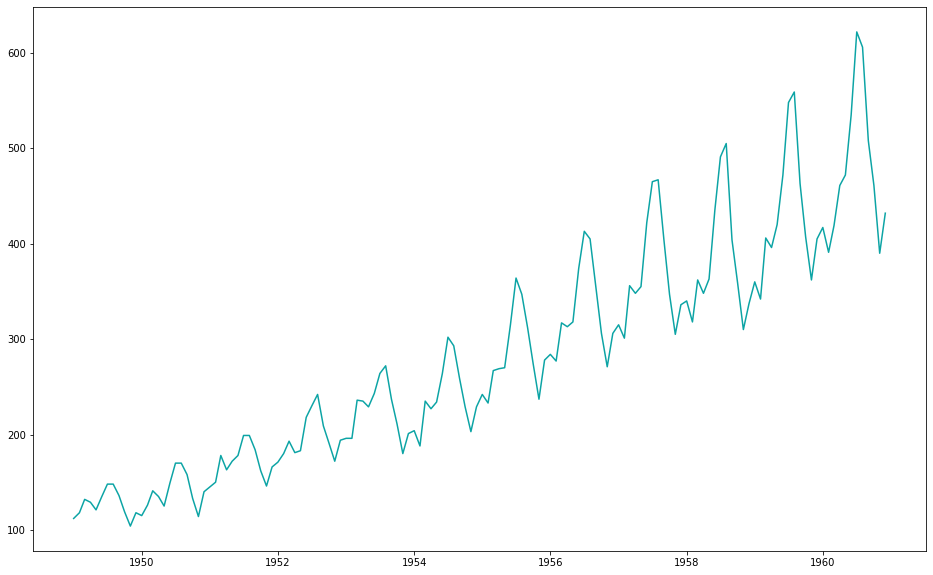

Количество наблюдений: 144


In [10]:
plt.figure(figsize=(16, 10))

plt.plot(data.Date, data.Passengers, c='#0CA4A5')
plt.show()

print(f'Количество наблюдений: {len(data)}')

In [11]:
data.columns

Index(['Month', 'Passengers', 'Date', 'Year', 'is_year_start', 'quarter'], dtype='object')

In [12]:
train_size = 100


# список признаков, по которым будем учить
features = ['Month', 'Passengers', 'Year', 'is_year_start', 'quarter']


# отступ теста от тренировки
bias = 4


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 5), (40, 5))

In [14]:
features = ['Month', 'Year', 'is_year_start', 'quarter']
target = 'Passengers'

In [15]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Month,Passengers,Year,is_year_start,quarter
0,-1.534863,112,-1.525724,3.179797,-1.287935
1,-1.247435,118,-1.525724,-0.314485,-1.287935
2,-0.960008,132,-1.525724,-0.314485,-1.287935
3,-0.672580,129,-1.525724,-0.314485,-0.399704
4,-0.385153,121,-1.525724,-0.314485,-0.399704


Формируем параметры для генерации выборки

In [16]:
# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 10
epochs = 20

In [17]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

8 108
32 112


In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 4), (100,), (32, 4), (32,))

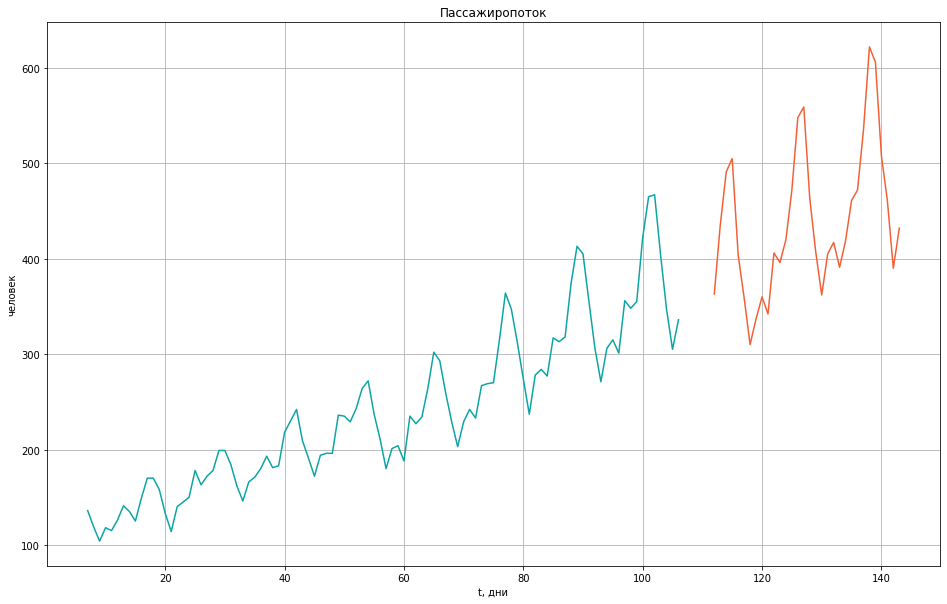

In [19]:
plt.figure(figsize=(16, 10))

plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:], c='#0CA4A5')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:], c='#F46036')
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('человек')
plt.title('Пассажиропоток')
plt.show()

In [20]:

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [21]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (10, 7, 4)
tf.Tensor(
[[-1.24743549 -1.52572369 -0.31448545 -1.28793522]
 [-0.96000796 -1.52572369 -0.31448545 -1.28793522]
 [-0.67258043 -1.52572369 -0.31448545 -0.39970403]
 [-0.38515289 -1.52572369 -0.31448545 -0.39970403]
 [-0.09772536 -1.52572369 -0.31448545 -0.39970403]
 [ 0.18970217 -1.52572369 -0.31448545  0.48852715]
 [ 0.4771297  -1.52572369 -0.31448545  0.48852715]], shape=(7, 4), dtype=float64)
Target shape: (10,)
tf.Tensor(119, shape=(), dtype=int64)


**сеть:  LSTM слои + Conv1D + Dense слой**

In [36]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model1 = Sequential()

model1.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model1.add(Conv1D(64, 3, activation='linear'))
model1.add(Flatten())
model1.add(Dense(3, activation='linear'))
model1.add(Dense(1, activation='linear'))

model1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 32)             4736      
                                                                 
 conv1d_7 (Conv1D)           (None, 5, 64)             6208      
                                                                 
 flatten_4 (Flatten)         (None, 320)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 963       
                                                                 
 dense_9 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,911
Trainable params: 11,911
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/25
10/10 [==============================] - 3s 76ms/step - loss: 58336.0781 - mae: 229.4868 - val_loss: 184932.5312 - val_mae: 425.0439
Epoch 2/25
10/10 [==============================] - 0s 18ms/step - loss: 58182.4844 - mae: 229.1412 - val_loss: 184475.2656 - val_mae: 424.5133
Epoch 3/25
10/10 [==============================] - 0s 19ms/step - loss: 58026.1875 - mae: 228.8517 - val_loss: 183831.6719 - val_mae: 423.7668
Epoch 4/25
10/10 [==============================] - 0s 18ms/step - loss: 57710.2891 - mae: 228.2430 - val_loss: 182618.0781 - val_mae: 422.3549
Epoch 5/25
10/10 [==============================] - 0s 20ms/step - loss: 56977.3984 - mae: 226.7978 - val_loss: 179957.4688 - val_mae: 419.2399
Epoch 6/25
10/10 [==============================] - 0s 18ms/step - loss: 55211.2695 - mae: 223.2482 - val_loss: 173891.8594 - val_mae: 412.0397
Epoch 7/25
10/10 [==============================] - 0s 19ms/step - loss: 51011.5430 - mae: 214.5138 - val_loss: 160474.6562 - val_mae: 3

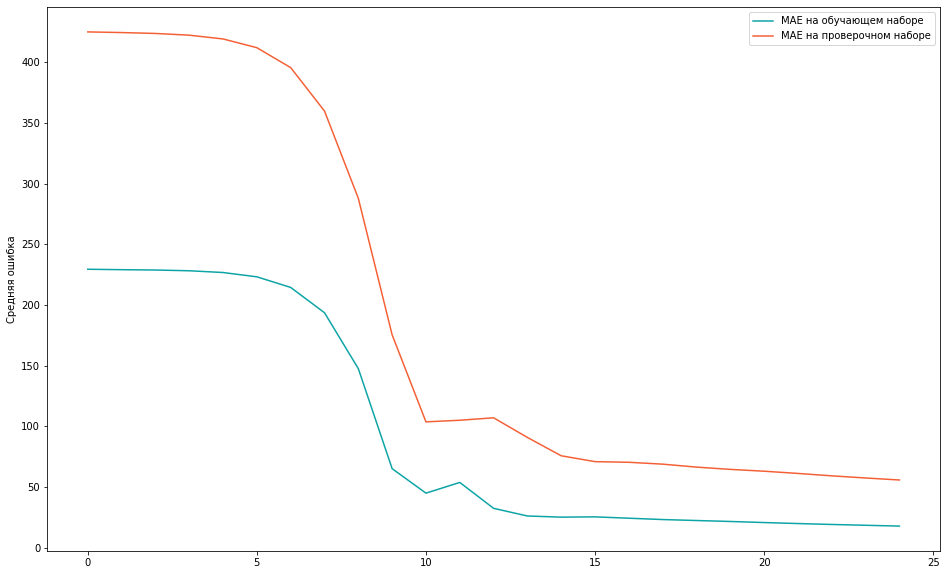

In [38]:
plt.figure(figsize=(16, 10))

plt.plot(history.history['mae'][:], label='MAE на обучающем наборе', c='#0CA4A5')
plt.plot(history.history['val_mae'][:], label='MAE на проверочном наборе', c='#F46036')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [39]:
# еще один слой конволюции

early_stop = EarlyStopping(monitor='val_mae', patience=5)

model2 = Sequential()

model2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
# model.add(LSTM(32, return_sequences=True))
model2.add(Conv1D(64, 3, activation='linear'))
model2.add(Conv1D(64, 1, activation='linear'))
model2.add(Flatten())
model2.add(Dense(3, activation='linear'))
model2.add(Dense(1, activation='linear'))

model2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 7, 32)             4736      
                                                                 
 conv1d_8 (Conv1D)           (None, 5, 64)             6208      
                                                                 
 conv1d_9 (Conv1D)           (None, 5, 64)             4160      
                                                                 
 flatten_5 (Flatten)         (None, 320)               0         
                                                                 
 dense_10 (Dense)            (None, 3)                 963       
                                                                 
 dense_11 (Dense)            (None, 1)                 4         
                                                                 
Total params: 16,071
Trainable params: 16,071
Non-trai

In [40]:
history = model2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/25
10/10 [==============================] - 5s 74ms/step - loss: 58412.6875 - mae: 229.5453 - val_loss: 185737.3125 - val_mae: 425.9755
Epoch 2/25
10/10 [==============================] - 0s 18ms/step - loss: 57896.3672 - mae: 228.3939 - val_loss: 184345.4844 - val_mae: 424.3603
Epoch 3/25
10/10 [==============================] - 0s 18ms/step - loss: 57199.5039 - mae: 227.0754 - val_loss: 181684.0312 - val_mae: 421.2474
Epoch 4/25
10/10 [==============================] - 0s 19ms/step - loss: 55140.9219 - mae: 223.0373 - val_loss: 174039.1562 - val_mae: 412.1644
Epoch 5/25
10/10 [==============================] - 0s 18ms/step - loss: 48763.5117 - mae: 209.9165 - val_loss: 151511.2344 - val_mae: 384.1302
Epoch 6/25
10/10 [==============================] - 0s 19ms/step - loss: 31777.6113 - mae: 169.1371 - val_loss: 95749.0703 - val_mae: 303.4054
Epoch 7/25
10/10 [==============================] - 0s 19ms/step - loss: 6393.2148 - mae: 65.9109 - val_loss: 20673.4668 - val_mae: 129.0

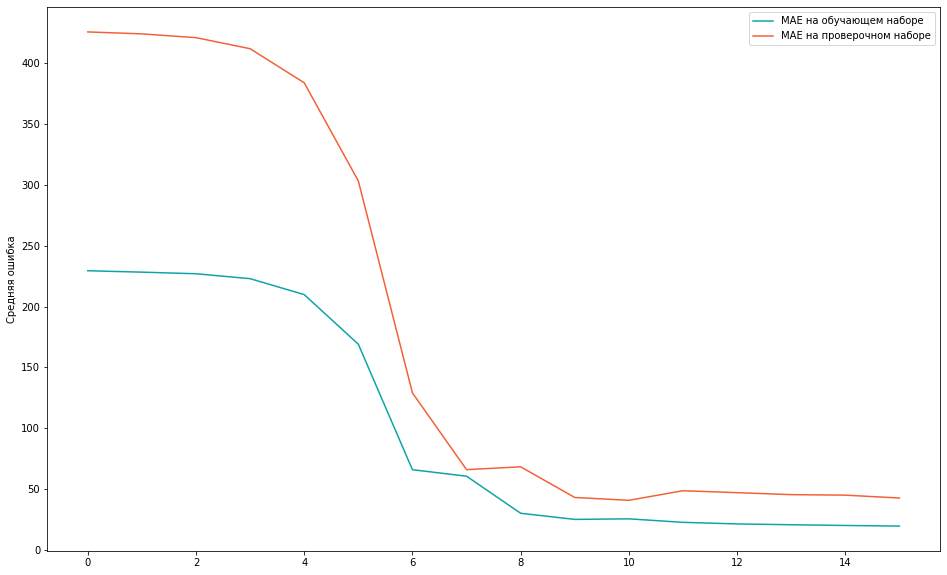

In [41]:
plt.figure(figsize=(16, 10))

plt.plot(history.history['mae'][:], label='MAE на обучающем наборе', c='#0CA4A5')
plt.plot(history.history['val_mae'][:], label='MAE на проверочном наборе', c='#F46036')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [47]:
# еще один слой LSTM

early_stop = EarlyStopping(monitor='val_mae', patience=5)

model3 = Sequential()

model3.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model3.add(LSTM(32, return_sequences=True))
model3.add(Conv1D(64, 3, activation='linear'))
model3.add(Conv1D(64, 1, activation='linear'))
model3.add(Flatten())
model3.add(Dense(3, activation='linear'))
model3.add(Dense(1, activation='linear'))

model3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 7, 32)             4736      
                                                                 
 lstm_13 (LSTM)              (None, 7, 32)             8320      
                                                                 
 conv1d_14 (Conv1D)          (None, 5, 64)             6208      
                                                                 
 conv1d_15 (Conv1D)          (None, 5, 64)             4160      
                                                                 
 flatten_8 (Flatten)         (None, 320)               0         
                                                                 
 dense_16 (Dense)            (None, 3)                 963       
                                                                 
 dense_17 (Dense)            (None, 1)                

In [48]:
history = model3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/25
10/10 [==============================] - 5s 125ms/step - loss: 58270.1758 - mae: 229.3976 - val_loss: 184506.5312 - val_mae: 424.5416
Epoch 2/25
10/10 [==============================] - 0s 21ms/step - loss: 57880.9883 - mae: 228.5902 - val_loss: 183217.5938 - val_mae: 423.0300
Epoch 3/25
10/10 [==============================] - 0s 21ms/step - loss: 56669.4531 - mae: 226.2365 - val_loss: 178292.7344 - val_mae: 417.2099
Epoch 4/25
10/10 [==============================] - 0s 21ms/step - loss: 51610.1719 - mae: 216.1967 - val_loss: 157559.1562 - val_mae: 391.7863
Epoch 5/25
10/10 [==============================] - 0s 24ms/step - loss: 32765.9570 - mae: 173.3317 - val_loss: 85769.8438 - val_mae: 286.7978
Epoch 6/25
10/10 [==============================] - 0s 21ms/step - loss: 1920.5808 - mae: 36.2458 - val_loss: 4972.2168 - val_mae: 53.5265
Epoch 7/25
10/10 [==============================] - 0s 23ms/step - loss: 10632.4688 - mae: 84.4436 - val_loss: 15357.3896 - val_mae: 110.8311

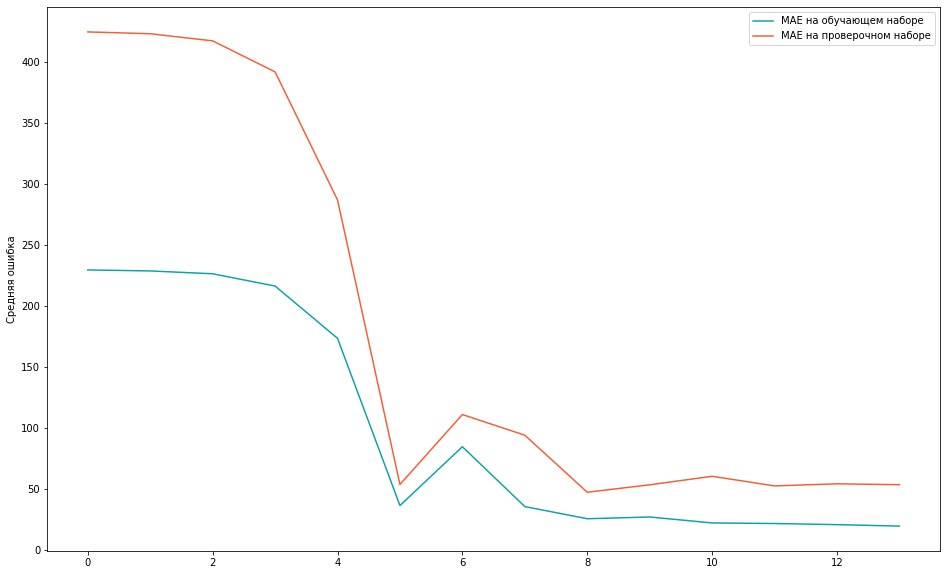

In [49]:
plt.figure(figsize=(16, 10))

plt.plot(history.history['mae'][:], label='MAE на обучающем наборе', c='#0CA4A5')
plt.plot(history.history['val_mae'][:], label='MAE на проверочном наборе', c='#F46036')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [50]:
# увеличим число эпох
epochs = 25

In [51]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model4 = Sequential()

model4.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model4.add(LSTM(32, return_sequences=True))
model4.add(Conv1D(64, 3, activation='linear'))
model4.add(Conv1D(64, 1, activation='linear'))
model4.add(Flatten())
model4.add(Dense(3, activation='linear'))
model4.add(Dense(1, activation='linear'))

model4.compile(loss='mse', optimizer='adam', metrics=['mae'])
model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 7, 32)             4736      
                                                                 
 lstm_15 (LSTM)              (None, 7, 32)             8320      
                                                                 
 conv1d_16 (Conv1D)          (None, 5, 64)             6208      
                                                                 
 conv1d_17 (Conv1D)          (None, 5, 64)             4160      
                                                                 
 flatten_9 (Flatten)         (None, 320)               0         
                                                                 
 dense_18 (Dense)            (None, 3)                 963       
                                                                 
 dense_19 (Dense)            (None, 1)               

In [52]:
history = model4.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/25
10/10 [==============================] - 6s 136ms/step - loss: 58290.1602 - mae: 229.4311 - val_loss: 184613.8438 - val_mae: 424.6689
Epoch 2/25
10/10 [==============================] - 0s 22ms/step - loss: 58069.2344 - mae: 228.9662 - val_loss: 183955.8906 - val_mae: 423.9015
Epoch 3/25
10/10 [==============================] - 0s 22ms/step - loss: 57385.9219 - mae: 227.6290 - val_loss: 181381.2656 - val_mae: 420.8908
Epoch 4/25
10/10 [==============================] - 0s 23ms/step - loss: 54381.7500 - mae: 221.7131 - val_loss: 169588.4688 - val_mae: 406.8168
Epoch 5/25
10/10 [==============================] - 0s 21ms/step - loss: 41918.6055 - mae: 195.3059 - val_loss: 121987.5391 - val_mae: 344.1324
Epoch 6/25
10/10 [==============================] - 0s 25ms/step - loss: 9439.3799 - mae: 92.3503 - val_loss: 20098.5117 - val_mae: 132.1812
Epoch 7/25
10/10 [==============================] - 0s 25ms/step - loss: 7832.0151 - mae: 74.6904 - val_loss: 10897.9316 - val_mae: 92.102

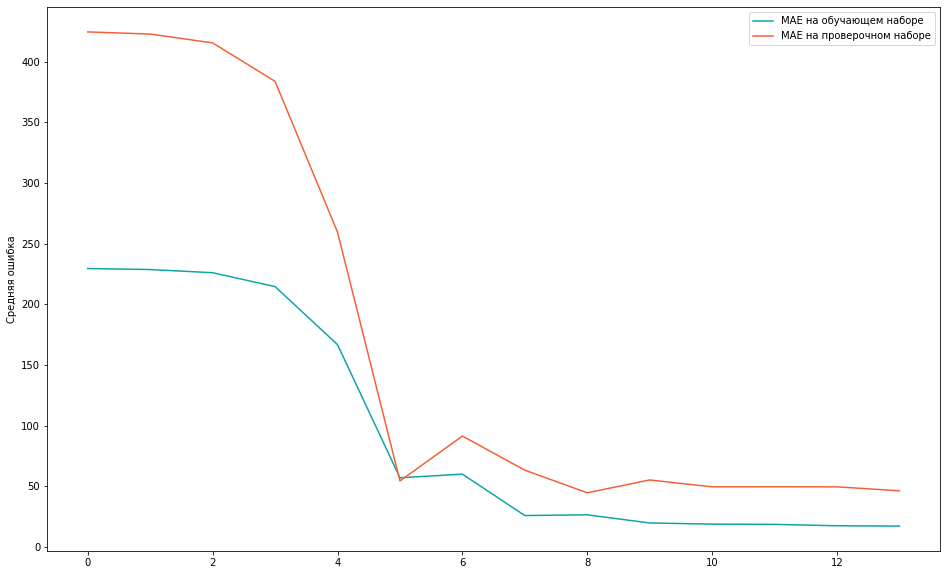

In [34]:
plt.figure(figsize=(16, 10))

plt.plot(history.history['mae'][:], label='MAE на обучающем наборе', c='#0CA4A5')
plt.plot(history.history['val_mae'][:], label='MAE на проверочном наборе', c='#F46036')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

сделаем предсказание

Самая лучшая модель - LSTM два слоя и два слоя конволюции. Число эпох - 25. Сделаем предсказание модели

In [65]:
pred = model4.predict(dataset_train).flatten()
pred_val = model4.predict(dataset_val).flatten()

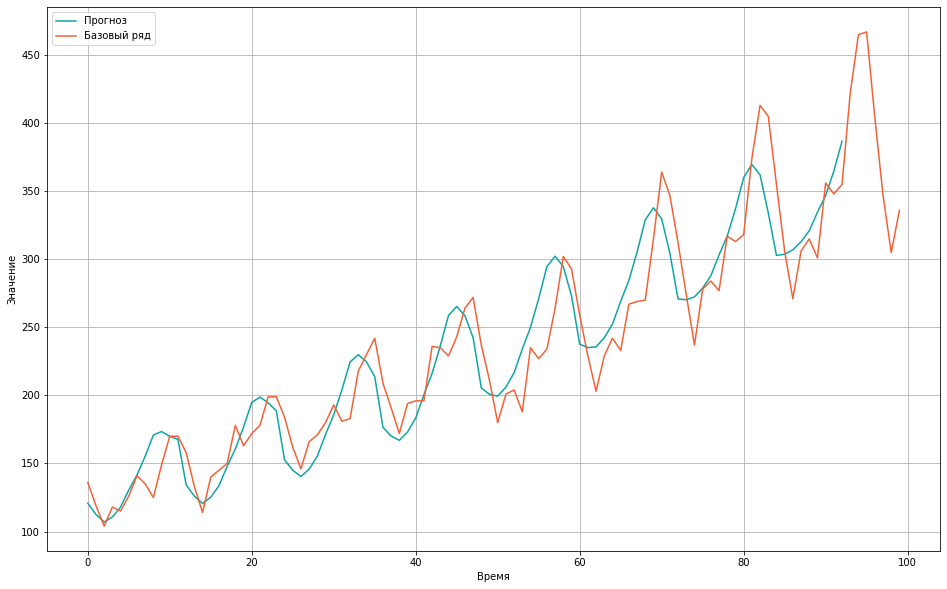

In [66]:
start = 0

plt.figure(figsize=(16, 10))
plt.grid('on')
plt.plot(pred[future + start: future + train_size], label='Прогноз', c='#0CA4A5')
plt.plot(y_train.flatten()[start: train_size], label='Базовый ряд', c='#F46036')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()

plt.show()

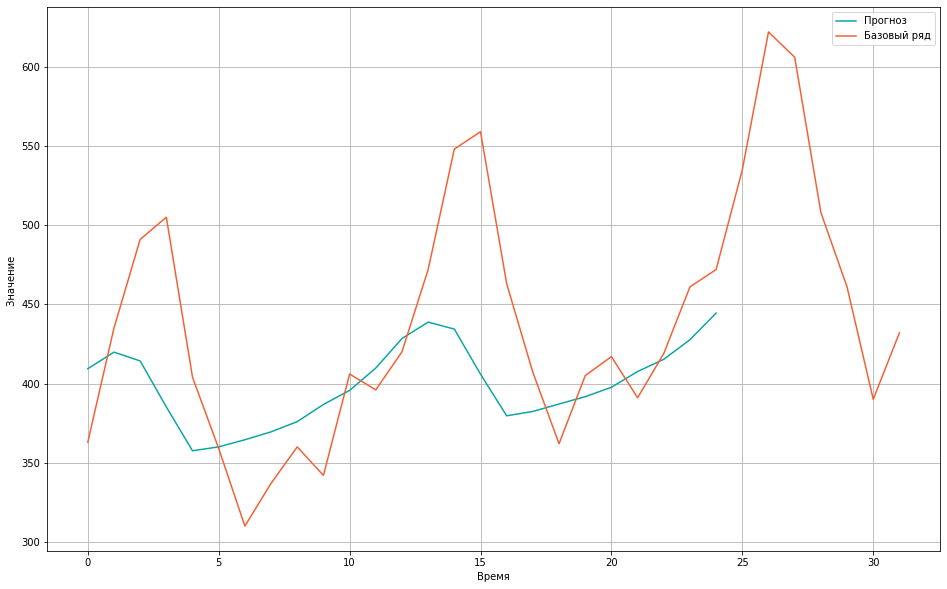

In [67]:
start = 0
step = 50
plt.figure(figsize=(16, 10))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], label='Прогноз', c='#0CA4A5')
plt.plot(y_val.flatten()[start: start+step], label='Базовый ряд', c='#F46036')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()